<a href="https://colab.research.google.com/github/Thanishaa27/dog-breed-identifier/blob/main/projectdogbreed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"thanishas","key":"f2b28eef255137696e58b3f99be4e11d"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!mkdir dog_dataset
%cd dog_dataset

/content/dog_dataset


In [ ]:
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

Dataset URL: https://www.kaggle.com/datasets/catherinehorng/dogbreedidfromcomp
License(s): unknown
100% 691M/691M [00:38<00:00, 22.8MB/s]
100% 691M/691M [00:38<00:00, 18.6MB/s]
/content


In [ ]:
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample_submission.csv

Streaming output truncated to the last 5000 lines.
  inflating: dog_dataset/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: dog_dataset/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dog_dataset/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dog_dataset/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dog_dataset/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dog_dataset/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dog_dataset/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dog_dataset/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dog_dataset/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dog_dataset/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dog_dataset/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dog_dataset/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: dog_dataset/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: dog_dataset/train/840db91b

In [ ]:
import cv2
import numpy as np
import pandas as pd
from pandas.testing import assert_frame_equal

# Use the imported functions or classes without causing a circular import
import collections
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model,Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

In [ ]:
df_labels=pd.read_csv('dog_dataset/labels.csv')
train_file='/content/dog_dataset/train'
test_file='/content/dog_dataset/test'

In [ ]:
df_labels.head()


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
print("Total number of unique Dog Breeds :",df_labels['breed'].nunique())

Total number of unique Dog Breeds : 120


In [ ]:
cleaned_label_list=[]
for breed in df_labels['breed']:
  cleaned_label_list.append(breed.replace('_','-').title())

In [ ]:
frequency=collections.Counter(cleaned_label_list)
data={'Breed': list(frequency.keys()),"Count": list(frequency.values())}
viz=pd.DataFrame(data)
viz.head()

,Breed,Count
0,Boston-Bull,87
1,Dingo,80
2,Pekinese,75
3,Bluetick,85
4,Golden-Retriever,67


In [ ]:
viz['Breed'].unique()

array(['Boston-Bull', 'Dingo', 'Pekinese', 'Bluetick', 'Golden-Retriever',
       'Bedlington-Terrier', 'Borzoi', 'Basenji', 'Scottish-Deerhound',
       'Shetland-Sheepdog', 'Walker-Hound', 'Maltese-Dog',
       'Norfolk-Terrier', 'African-Hunting-Dog',
       'Wire-Haired-Fox-Terrier', 'Redbone', 'Lakeland-Terrier', 'Boxer',
       'Doberman', 'Otterhound', 'Standard-Schnauzer',
       'Irish-Water-Spaniel', 'Black-And-Tan-Coonhound', 'Cairn',
       'Affenpinscher', 'Labrador-Retriever', 'Ibizan-Hound',
       'English-Setter', 'Weimaraner', 'Giant-Schnauzer', 'Groenendael',
       'Dhole', 'Toy-Poodle', 'Border-Terrier', 'Tibetan-Terrier',
       'Norwegian-Elkhound', 'Shih-Tzu', 'Irish-Terrier', 'Kuvasz',
       'German-Shepherd', 'Greater-Swiss-Mountain-Dog', 'Basset',
       'Australian-Terrier', 'Schipperke', 'Rhodesian-Ridgeback',
       'Irish-Setter', 'Appenzeller', 'Bloodhound', 'Samoyed',
       'Miniature-Schnauzer', 'Brittany-Spaniel', 'Kelpie', 'Papillon',
       'Borde

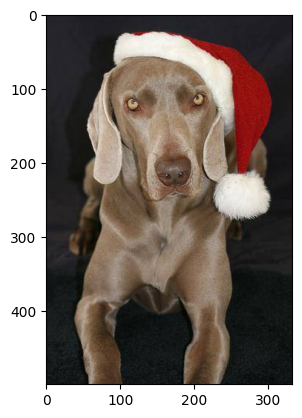

In [ ]:
import glob
image_files = glob.glob("/content/dog_dataset/train/*.jpg")
img = Image.open(image_files[0])
plt.imshow(img)

In [ ]:
fig=px.scatter(viz,x="Breed",y="Count",hover_name="Breed",size="Count")
fig.show()

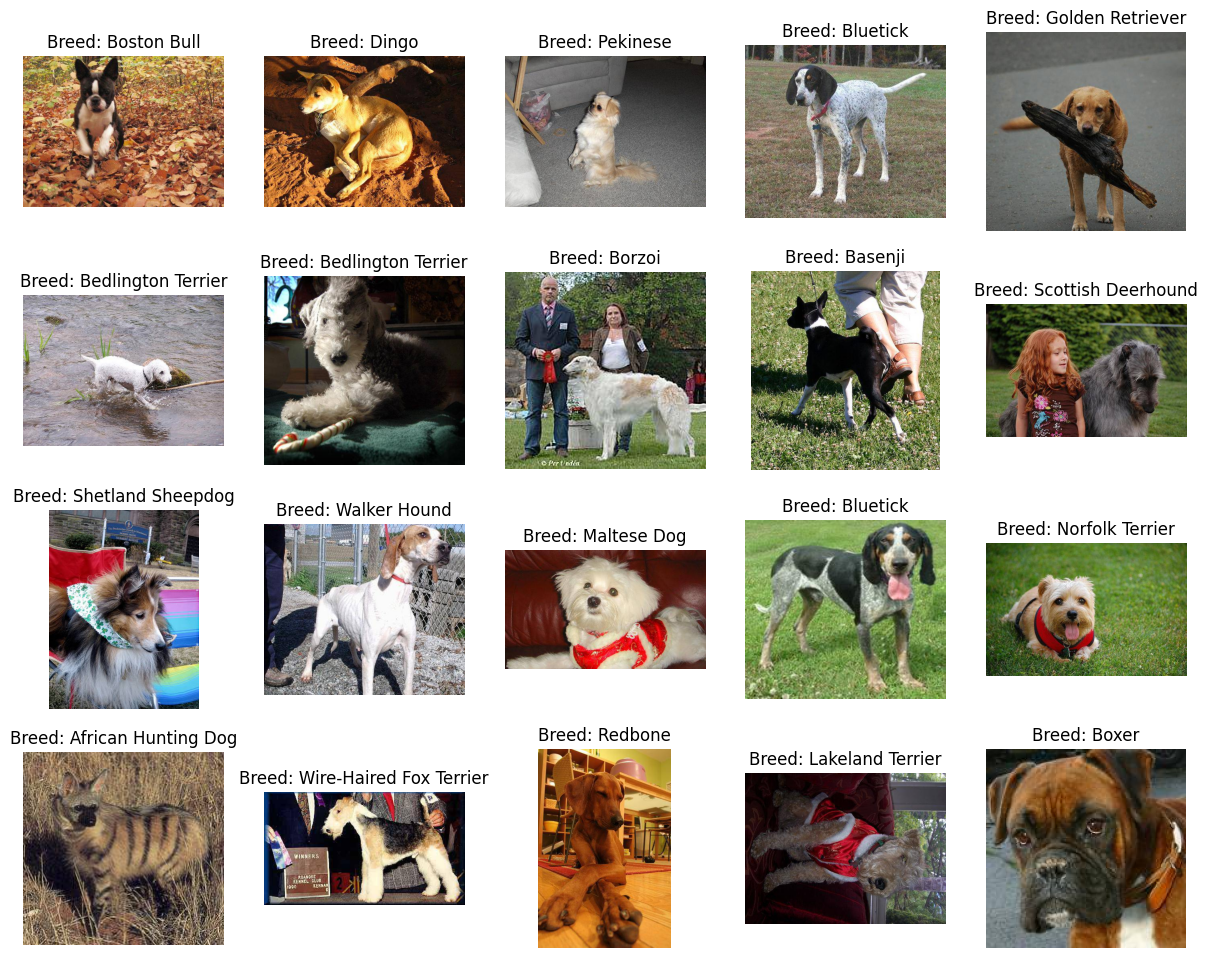

In [ ]:
files=df_labels.iloc[0:20]
plt.figure(figsize=(15,15))
for index,name,breed in files.itertuples():
  plt.subplot(5,5,index+1)
  img=load_img("/content/dog_dataset/train/"+name+".jpg")
  img=np.array(img)
  plt.imshow(img)
  plt.title("Breed: {}".format(breed.replace("_"," ").title()))
  plt.axis("off")

In [ ]:
num_breeds=60
im_size=224
batch_size=32
encoder= LabelEncoder()


In [ ]:
breed_dict=list(df_labels["breed"].value_counts().keys())
neew_list=sorted(breed_dict,reverse=True)[: num_breeds*2+1:2]
df_labels=df_labels.query('breed in @neew_list')


In [ ]:
import requests
from bs4 import BeautifulSoup
def info(breed):
    url=f"https://www.akc.org/dog-breeds/{breed}"
    response=requests.get(url)
    soup=BeautifulSoup(response.text,"html.parser")
    paragraphs=soup.find(class_="share.model__content-inner mt3")
    return(paragraphs)

In [ ]:
change=[]
for i in neew_list:
  i=i.replace('_','-')
  if(info(i)==None):
     change.append(i)
change[:5]

['yorkshire-terrier',
 'whippet',
 'welsh-springer-spaniel',
 'walker-hound',
 'toy-terrier']

In [ ]:
change_=[]
for i in change:
     change_.append(i.replace('-','_'))
change_[:5]

['yorkshire_terrier',
 'whippet',
 'welsh_springer_spaniel',
 'walker_hound',
 'toy_terrier']

In [ ]:
new_name = ['treeing_walker_coonhound', 'toy_fox_terrier', 'poodle_standard', 'redbone_coonhound', 'pekingese', 'maltese', 'alasakan_malamute', 'leonberger', 'australian_kelpie', 'japanese_chin', 'german_shorthaired_pointer', 'american_eskimo_dog', 'english_springer_spaniel', 'carolina_dog', 'dandie_dinmont_terrier', 'clumber_spaniel', 'cardigan_welsh_corgi', 'bullmastiff', 'boston_terrier', 'bluetick_coonhound', 'cavalier_king_charles_spaniel', 'apanzeller_sennenhund', 'airedale_terrifier']

In [ ]:
new_names_dict={}
for key in  change:
  for value in new_name:
    new_names_dict[key]=value
    new_name.remove(value)
    break


In [ ]:
df_labels.replace({'breed' :new_names_dict},inplace=True)

In [ ]:
df_labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,bullmastiff
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
df_labels['/content/dog_dataset/train']=df_labels['id'].apply(lambda x: x+'.jpg')
df_labels.head()

,id,breed,/content/dog_dataset/train
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,bullmastiff,001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,0021f9ceb3235effd7fcde7f7538ed62.jpg


In [ ]:
train_x=np.zeros((len(df_labels),im_size,im_size,3),dtype='float32')
for i, img_id in enumerate(df_labels['/content/dog_dataset/train']):
  img = cv2.resize(cv2.imread('/content/dog_dataset/train/' + img_id,cv2.IMREAD_COLOR),((im_size,im_size)))
  img_array=preprocess_input(np.expand_dims(np.array(img[...,::-1].astype(np.float32)).copy(),axis=0))
  train_x[i]=img_array

In [ ]:
train_y=encoder.fit_transform(df_labels['breed'].values)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=45,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode="nearest")
train_generator=train_datagen.flow(x_train,y_train,batch_size=batch_size)
test_datagen=ImageDataGenerator()
test_generator=test_datagen.flow(x_test,y_test,batch_size=batch_size)

In [ ]:
resnet= ResNet50V2(input_shape=[im_size,im_size,3],include_top=False,weights='imagenet')
for layer in resnet.layers:
  layer.trainable=False
  x=resnet.output
  x=BatchNormalization()(x)
  x=GlobalAveragePooling2D()(x)
  x=Dropout(0.5)(x)
  x=Dense(1024,activation='relu')(x)
  x=Dropout(0.5)(x)

94668760/94668760 [==============================] - 5s 0us/step


In [ ]:
predictions=Dense(num_breeds,activation='softmax')(x)
model=Model(inputs=resnet.input,outputs=predictions)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

In [ ]:
# Training the model
epochs =20
learning_rate=1e-3
optimizer=RMSprop(learning_rate=learning_rate,rho=0.9)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
hist=model.fit(train_generator,steps_per_epoch=x_train.shape[0]//batch_size,epochs=epochs,validation_data=test_generator,validation_steps=x_test.shape[0]//batch_size)


Epoch 1/20
129/129 [==============================] - 66s 431ms/step - loss: 2.0657 - accuracy: 0.4593 - val_loss: 0.7734 - val_accuracy: 0.7461
Epoch 2/20
129/129 [==============================] - 56s 434ms/step - loss: 1.2395 - accuracy: 0.6366 - val_loss: 0.6868 - val_accuracy: 0.7900
Epoch 3/20
129/129 [==============================] - 58s 449ms/step - loss: 1.1324 - accuracy: 0.6709 - val_loss: 0.6852 - val_accuracy: 0.7900
Epoch 4/20
129/129 [==============================] - 54s 420ms/step - loss: 1.0278 - accuracy: 0.6989 - val_loss: 0.7034 - val_accuracy: 0.7939
Epoch 5/20
129/129 [==============================] - 57s 442ms/step - loss: 1.0537 - accuracy: 0.6952 - val_loss: 0.7387 - val_accuracy: 0.7871
Epoch 6/20
129/129 [==============================] - 55s 425ms/step - loss: 0.9791 - accuracy: 0.7098 - val_loss: 0.7053 - val_accuracy: 0.8047
Epoch 7/20
129/129 [==============================] - 59s 456ms/step - loss: 0.9386 - accuracy: 0.7317 - val_loss: 0.7668 - val_ac

In [ ]:
model.save("dogbreed_10epoch_weights.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [ ]:
epochs=10
batch_size=32

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
predictions=model.predict(x_test)
predictions

33/33 [==============================] - 184s 5s/step


array([[7.7406957e-04, 4.7775303e-04, 4.7059334e-06, ..., 1.1291419e-06,
        9.3027520e-06, 2.9222510e-04],
       [4.2369100e-04, 8.4057236e-03, 5.3913367e-04, ..., 6.3784630e-04,
        2.0757585e-04, 1.1175638e-03],
       [9.9950594e-01, 4.2574422e-07, 9.2262191e-08, ..., 2.6482447e-09,
        1.5714652e-07, 1.5391710e-07],
       ...,
       [3.2888358e-06, 8.4782747e-05, 3.5486750e-07, ..., 2.9685432e-07,
        2.4050451e-07, 1.3946634e-04],
       [1.5942134e-05, 6.7006554e-06, 7.8333069e-06, ..., 2.0755306e-04,
        7.0308614e-01, 3.0153321e-06],
       [7.7660970e-06, 5.9554786e-06, 4.4654720e-05, ..., 2.0430943e-04,
        8.9534785e-07, 2.5346703e-06]], dtype=float32)

In [ ]:
filename="breeds01_dog.h5"
model.save(filename)

In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model(filename)
pred = loaded_model.predict(x_test)
pred

NameError: name 'filename' is not defined